<a href="https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/imagewang_02_use_pseudolabels_to_train_student_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
1. Use the generated pseudo-labels to train (csv 2)


In [ ]:
%%capture
!pip install --upgrade fastai

# Set up data

In [ ]:
import os
from pathlib import Path, PurePath
import pandas as pd
from fastai.vision.all import *
from fastai.test_utils import show_install
show_install()



```text
=== Software === 
python        : 3.6.9
fastai        : 2.2.5
fastprogress  : 0.2.7
torch         : 1.7.0+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : Tesla T4

=== Environment === 
platform      : Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Jul 23 08:00:38 PDT 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run this utilit

In [ ]:
path = untar_data(URLs.IMAGEWANG)
path.ls()

(#3) [Path('/root/.fastai/data/imagewang/unsup'),Path('/root/.fastai/data/imagewang/val'),Path('/root/.fastai/data/imagewang/train')]

In [ ]:
%ls '/root/.fastai/data/imagewang/train'

n01440764/  n02089973/  n02102040/  n02979186/  n03417042/
n02086240/  n02093754/  n02105641/  n03000684/  n03425413/
n02087394/  n02096294/  n02111889/  n03028079/  n03445777/
n02088364/  n02099601/  n02115641/  n03394916/  n03888257/


create train and val df from folders

1. mount google drive
2. generate `df_train`, `df_val` from path with `is_valid` column
3. merge `[df_train, df_val, df_pseudolabels]`
4. Set up dataloader with same augmentations

In [ ]:
all_fnames = []
all_labels = []
for r, d, f in os.walk(f"{path}/train"):
    if not d:
        fnames = [f"{r}/{fname}" for fname in f]
        labels = [PurePath(fname).parent.name for fname in fnames]
        all_fnames.extend(fnames)
        all_labels.extend(labels)

is_valid = [False]* len(all_fnames)


df_train = pd.DataFrame({"fname":all_fnames, "class":all_labels, "is_valid":is_valid})
df_train.head(5)


,fname,class,is_valid
0,/root/.fastai/data/imagewang/train/n03028079/n03028079_3254.JPEG,n03028079,False
1,/root/.fastai/data/imagewang/train/n03028079/n03028079_1008.JPEG,n03028079,False
2,/root/.fastai/data/imagewang/train/n03028079/n03028079_10596.JPEG,n03028079,False
3,/root/.fastai/data/imagewang/train/n03028079/n03028079_2036.JPEG,n03028079,False
4,/root/.fastai/data/imagewang/train/n03028079/n03028079_28938.JPEG,n03028079,False


In [ ]:
all_fnames = []
all_labels = []
for r, d, f in os.walk(f"{path}/val"):
    if not d:
        fnames = [f"{r}/{fname}" for fname in f]
        labels = [PurePath(fname).parent.name for fname in fnames]
        all_fnames.extend(fnames)
        all_labels.extend(labels)

is_valid = [True]* len(all_fnames)


df_val = pd.DataFrame({"fname":all_fnames, "class":all_labels, "is_valid":is_valid})
df_val.head(5)

,fname,class,is_valid
0,/root/.fastai/data/imagewang/val/n02099601/n02099601_8420.JPEG,n02099601,True
1,/root/.fastai/data/imagewang/val/n02099601/n02099601_10912.JPEG,n02099601,True
2,/root/.fastai/data/imagewang/val/n02099601/n02099601_28691.JPEG,n02099601,True
3,/root/.fastai/data/imagewang/val/n02099601/n02099601_10412.JPEG,n02099601,True
4,/root/.fastai/data/imagewang/val/n02099601/n02099601_26980.JPEG,n02099601,True


In [ ]:
df_val.tail(5)

,fname,class,is_valid
3924,/root/.fastai/data/imagewang/val/n02111889/n02111889_12811.JPEG,n02111889,True
3925,/root/.fastai/data/imagewang/val/n02111889/n02111889_4022.JPEG,n02111889,True
3926,/root/.fastai/data/imagewang/val/n02111889/n02111889_6950.JPEG,n02111889,True
3927,/root/.fastai/data/imagewang/val/n02111889/n02111889_2442.JPEG,n02111889,True
3928,/root/.fastai/data/imagewang/val/n02111889/n02111889_9642.JPEG,n02111889,True


load pseudolabels

In [ ]:

df_pseudolabels = pd.read_csv("/content/drive/MyDrive/imagewang tests/pseudolabels_05.csv")
df_pseudolabels = df_pseudolabels.drop("Unnamed: 0",axis=1)
df_pseudolabels["is_valid"]=False
df_pseudolabels.head(5)

,fname,class,is_valid
0,/root/.fastai/data/imagewang/unsup/n02111889_16.JPEG,n02111889,False
1,/root/.fastai/data/imagewang/unsup/n02111889_13497.JPEG,n02099601,False
2,/root/.fastai/data/imagewang/unsup/n02096294_7724.JPEG,n02096294,False
3,/root/.fastai/data/imagewang/unsup/n02115641_9685.JPEG,n03000684,False
4,/root/.fastai/data/imagewang/unsup/n02105641_11847.JPEG,n02105641,False


In [ ]:
df_pseudolabels.tail(5)

,fname,class,is_valid
7745,/root/.fastai/data/imagewang/unsup/n02115641_8793.JPEG,n02099601,False
7746,/root/.fastai/data/imagewang/unsup/n02115641_2186.JPEG,n02115641,False
7747,/root/.fastai/data/imagewang/unsup/n02088364_8026.JPEG,n02088364,False
7748,/root/.fastai/data/imagewang/unsup/n02093754_7537.JPEG,n03394916,False
7749,/root/.fastai/data/imagewang/unsup/n02096294_73.JPEG,n02093754,False


merge all 3 dfs together

In [ ]:
df = pd.concat([df_train, df_pseudolabels, df_val])
print(df.shape)
df.head(5)

(26348, 3)


,fname,class,is_valid
0,/root/.fastai/data/imagewang/train/n03028079/n03028079_3254.JPEG,n03028079,False
1,/root/.fastai/data/imagewang/train/n03028079/n03028079_1008.JPEG,n03028079,False
2,/root/.fastai/data/imagewang/train/n03028079/n03028079_10596.JPEG,n03028079,False
3,/root/.fastai/data/imagewang/train/n03028079/n03028079_2036.JPEG,n03028079,False
4,/root/.fastai/data/imagewang/train/n03028079/n03028079_28938.JPEG,n03028079,False


creating dataloader from df

In [ ]:
# defining batch and individual image transforms
size = 224
tfms = aug_transforms(size=size, max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.)) # used to get images all the same size

# batch transforms
batch_tfms = [*tfms, Normalize.from_stats(*imagenet_stats)]

# creating dataloader
dl = ImageDataLoaders.from_df(df=df, path = "/", fn_col="fname", label_col="class", valid_col="is_valid", batch_tfms=batch_tfms, item_tfms=item_tfms, bs=64)


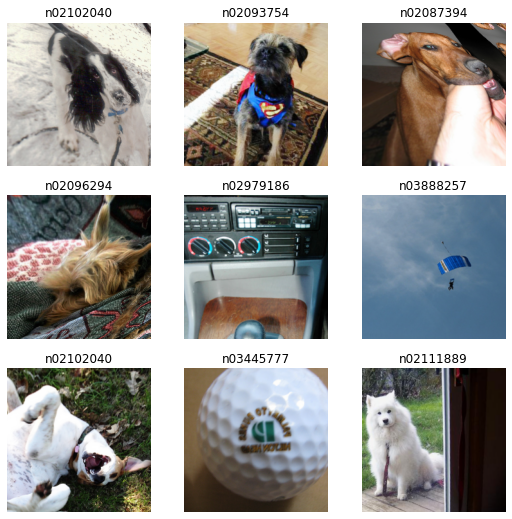

In [ ]:
dl.show_batch()

In [ ]:
dl.vocab

['n01440764', 'n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02102040', 'n02105641', 'n02111889', 'n02115641', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']

In [ ]:
dl.vocab.o2i

{'n01440764': 0,
 'n02086240': 1,
 'n02087394': 2,
 'n02088364': 3,
 'n02089973': 4,
 'n02093754': 5,
 'n02096294': 6,
 'n02099601': 7,
 'n02102040': 8,
 'n02105641': 9,
 'n02111889': 10,
 'n02115641': 11,
 'n02979186': 12,
 'n03000684': 13,
 'n03028079': 14,
 'n03394916': 15,
 'n03417042': 16,
 'n03425413': 17,
 'n03445777': 18,
 'n03888257': 19}

# 1. Training on all data

In [ ]:
# need to use this to get rid of a typeerror in learner
def get_model(model, pretrained=False, **kwargs):
    """model: function to load the model, e.g. resnet18
        pretrained, progress: to be passed to the model function
    """
    m = model(pretrained=pretrained, **kwargs) # loads standard model

    return m


In [ ]:
# hyperparameters for ranger

# optional: use the ranger library
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

# use no pretrained weights
# use xresnet instead of standard resnet
learn = cnn_learner(dl, 
                    partial(get_model, model=xresnet34, pretrained=False),
                    metrics=accuracy,
                    loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=opt_func).to_fp16()



In [ ]:
learn.unfreeze();

# learn.summary()


train from scratch

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=1.5848931980144698e-06)

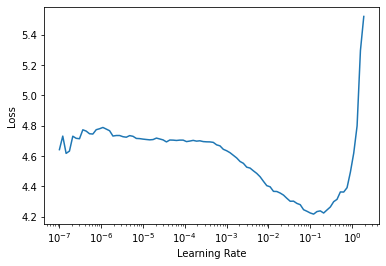

In [ ]:
learn.lr_find()

In [ ]:
# callbacks
# reduce lr on plateau has lower patience than early stopping so model gets a chance to improve before stopping training
use_mixup = False
model_fname = "/content/drive/MyDrive/imagewang tests/model_psuedo_04"

cbs = [
    ReduceLROnPlateau(monitor='accuracy',factor=5,patience=3),
    EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=4),
    SaveModelCallback(monitor="accuracy", fname=model_fname)
]
if use_mixup:
    cbs.append(MixUp(0.4))
print(cbs)

[ReduceLROnPlateau, EarlyStoppingCallback, SaveModelCallback]


In [ ]:
lr = 0.01
pct_start = 0.3
n_epochs = 20
learn.fit_flat_cos(n_epochs, lr=lr, pct_start=pct_start, cbs=cbs)


epoch,train_loss,valid_loss,accuracy,time
0,2.072156,2.855662,0.172054,04:13
1,1.751556,2.787344,0.288623,04:14
2,1.567816,2.223715,0.384576,04:13
3,1.460808,1.827415,0.518198,04:13
4,1.397303,1.940102,0.493255,04:12
5,1.336886,2.219339,0.406719,04:12
6,1.297400,1.786331,0.545431,04:13
7,1.271947,1.814807,0.534233,04:13
8,1.239611,1.840767,0.530415,04:13
9,1.180873,1.835858,0.538559,04:12


Better model found at epoch 0 with accuracy value: 0.1720539629459381.
Better model found at epoch 1 with accuracy value: 0.28862306475639343.
Better model found at epoch 2 with accuracy value: 0.3845762312412262.
Better model found at epoch 3 with accuracy value: 0.5181980133056641.
Better model found at epoch 6 with accuracy value: 0.5454314351081848.
Epoch 9: reducing lr to 0.00162399467837859
Better model found at epoch 10 with accuracy value: 0.5785186886787415.
Better model found at epoch 12 with accuracy value: 0.5937897562980652.
Better model found at epoch 14 with accuracy value: 0.6268770694732666.
Epoch 17: reducing lr to 9.93284997238577e-05
No improvement since epoch 14: early stopping


## Results
https://docs.google.com/spreadsheets/d/1nS1_C2y73EpRgvjQ1bhBmnHhev1LVMOU57mZeDpEL6k/edit?usp=sharing

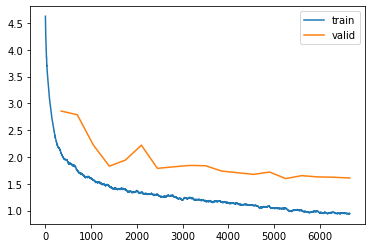

In [ ]:
learn.recorder.plot_loss()

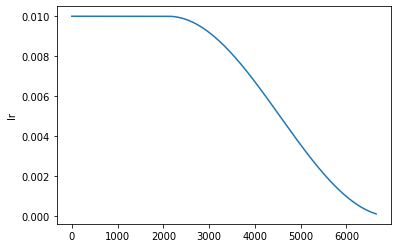

In [ ]:
learn.recorder.plot_sched()

# fine-tune from labelled+pseudolabels on only labelled data

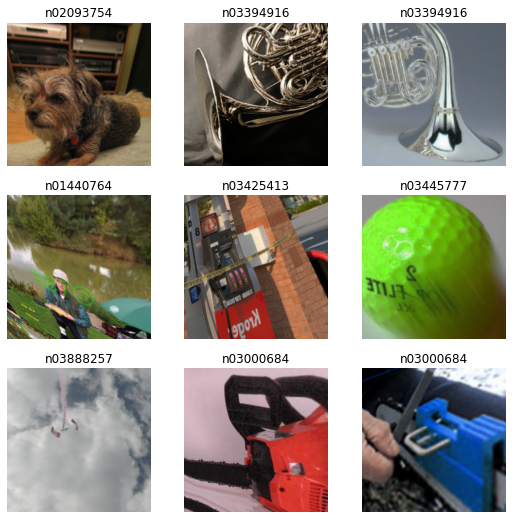

In [ ]:
df_labelled = pd.concat([df_train, df_val])
dl_labelled = ImageDataLoaders.from_df(df=df_labelled, path = "/", fn_col="fname", label_col="class", valid_col="is_valid", batch_tfms=batch_tfms, item_tfms=item_tfms, bs=64)
dl_labelled.show_batch()

In [ ]:
learn_2 = cnn_learner(dl_labelled, 
                    partial(get_model, model=xresnet34, pretrained=False),
                    metrics=accuracy,
                    loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=opt_func).to_fp16()

learn_2.load(model_fname)
# learn.to_fp16()
learn_2.unfreeze()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
learn_2.summary();

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=2.2908675418875646e-06)

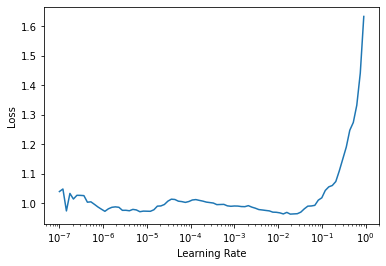

In [ ]:
learn_2.lr_find()

In [ ]:
model_fname

'/content/drive/MyDrive/imagewang tests/model_psuedo_04'

In [ ]:
# to make sure validation accuracy matches the model
learn_2.validate()

(#2) [1.5954023599624634,0.6268770694732666]

In [ ]:
use_mixup = False
model_fname_2 = "/content/drive/MyDrive/imagewang tests/model_psuedo_finetune_04_stage2"

cbs = [
    ReduceLROnPlateau(monitor='accuracy',factor=5,patience=3),
    EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=4),
    SaveModelCallback(monitor="accuracy", fname=model_fname_2)
]
if use_mixup:
    cbs.append(MixUp(0.4))
print(cbs)

[ReduceLROnPlateau, EarlyStoppingCallback, SaveModelCallback]


In [ ]:
lr = 3e-3
pct_start = 0.3
n_epochs = 20
learn_2.fit_flat_cos(n_epochs, lr=lr, pct_start=pct_start, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.870470,1.492868,0.648766,03:00
1,0.872660,1.511263,0.653601,02:59
2,0.857452,1.557315,0.628913,03:01
3,0.835023,1.592768,0.618223,03:02
4,0.836413,1.591102,0.626623,03:01


Better model found at epoch 0 with accuracy value: 0.6487655639648438.
Better model found at epoch 1 with accuracy value: 0.6536014080047607.
Epoch 4: reducing lr to 0.0006000000000000001
No improvement since epoch 0: early stopping


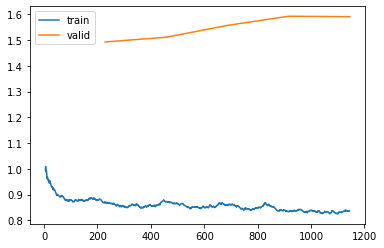

In [ ]:
learn_2.recorder.plot_loss()

## predict pseudo-labels again

predict with `get_preds`

do we need to make sure it's ordered? (doesn't seem like its needed)

In [ ]:
learn_2.load(model_fname_2)
learn_2.validate()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#2) [1.511251449584961,0.6536014080047607]

In [ ]:
path

Path('/root/.fastai/data/imagewang')

In [ ]:
test_imgs = get_image_files(f"{path}/unsup")
dl_test = learn_2.dls.test_dl(test_imgs)

In [ ]:
res = learn_2.get_preds(dl=dl_test, with_decoded=True)

In [ ]:
len(res)

3

`res` is a tuple of length 3 (2 if `with_decoded = False`)

`res[0]` is the raw logits -> a tensor with shape `[n, k]`

`res[1]` is the input labels, will be empty if labels not provided

`res[2]` is the decoded input labels, is a 1d tensor with shape `[n, 1]`

In [ ]:
res[0].shape

torch.Size([7750, 20])

In [ ]:
res[1]

In [ ]:
res[2].shape

torch.Size([7750])

In [ ]:
pred_class = res[2].cpu().numpy()

In [ ]:
pred_class

array([ 7,  3, 10, ...,  7, 13,  6])

In [ ]:
# convert back into original labels
i2o = {v:k for k,v in dl.vocab.o2i.items()}
i2o

{0: 'n01440764',
 1: 'n02086240',
 2: 'n02087394',
 3: 'n02088364',
 4: 'n02089973',
 5: 'n02093754',
 6: 'n02096294',
 7: 'n02099601',
 8: 'n02102040',
 9: 'n02105641',
 10: 'n02111889',
 11: 'n02115641',
 12: 'n02979186',
 13: 'n03000684',
 14: 'n03028079',
 15: 'n03394916',
 16: 'n03417042',
 17: 'n03425413',
 18: 'n03445777',
 19: 'n03888257'}

In [ ]:
pred_class_orig = [i2o[k] for k in list(pred_class)]
pred_class_orig[:5]
# pred_class_orig

['n02099601', 'n02088364', 'n02111889', 'n02088364', 'n02105641']

In [ ]:
test_img_files = [str(f) for f in test_imgs]
test_img_files[:5]

['/root/.fastai/data/imagewang/unsup/n02099601_7437.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02089973_1143.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02111889_14606.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02089973_1106.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02105641_7804.JPEG']

In [ ]:
df_pseudo_labels = pd.DataFrame({"fname": test_img_files, "class": pred_class_orig})
df_pseudo_labels.head(5)

,fname,class
0,/root/.fastai/data/imagewang/unsup/n02099601_7437.JPEG,n02099601
1,/root/.fastai/data/imagewang/unsup/n02089973_1143.JPEG,n02088364
2,/root/.fastai/data/imagewang/unsup/n02111889_14606.JPEG,n02111889
3,/root/.fastai/data/imagewang/unsup/n02089973_1106.JPEG,n02088364
4,/root/.fastai/data/imagewang/unsup/n02105641_7804.JPEG,n02105641


## saving model weights and df_pseudo_labels to google drive

In [ ]:
df_pseudo_labels.to_csv("/content/drive/MyDrive/imagewang tests/pseudolabel_finetune_04_stage2.csv")